````
AESM1450 - Geophysical Prospecting  -- Controlled-Source ElectroMagnetic (CSEM) Modelling
````


# 3. Land 1D time domain

This is the same excercise as **2.a Land 1D frequency-domain**, but now in the time domain and with some more tasks.

Regarding time-domain modelling with `empymod`: The parameter `freqtime` in `empymod.dipole` takes either frequencies (Hz) or times (s). The flag to choose one or the other is `signal`, which is set by default to `None`:
- `signal = None`: Frequency domain
- `signal = -1`: Time domain; switch-off response
- `signal = 0`: Time domain; impulse response
- `signal = 1`: Time domain; switch-on response

Here we use the impulse response, so set the `signal` to 0.

In [1]:
import empymod
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
plt.style.use('ggplot')

## In the following two introductory examples to time-domain modelling:
1. Single offset, many times
2. Many offsets, many times

### Define model parameters for all three examples and tasks

In [3]:
# 1D depth model:
# - target at 2 km depth below seafloor, 40 m thick
depth = [0, -2000, -2040]

# Corresponding resistivity model:
res_bg = [2e14, 10, 10, 10]    # Background model
res_tgr = [2e14, 10, 300, 10]  # Resistive model
res_tgc = [2e14, 10, 0.3, 10]  # Conductive model

### Define survey parameters

In [4]:
# Infinitesimal small dipole source at
# x = 0 m, y = 0 m, z = 0 m 
src = [0, 0, 0]

# Receivers: 101 receivers from x=0.5-10 km, y=0, z=0
off = np.arange(5, 101)*100
rec = [off, off*0, 0]

# Impulse response
signal = 0

# Times: 301 times from 0.001-10 s
times = np.logspace(-3, 1, 301)

## Example 1: single offset, many times

In [5]:
# Get distinct receiver
ri = 45
rec1 = [rec[0][ri], rec[1][ri], rec[2]]
print(f"Offset: {rec1[0]/1e3} km")

inp = {
    'src': src,
    'rec': rec1,
    'freqtime': times,
    'signal': signal,
    'verb': 0,
    'epermH': [0, 1, 1, 1],  # To make t-domain early times more stable
    'epermV': [0, 1, 1, 1],
}

# Calculate it
resp_bg11 = empymod.dipole(depth=depth, res=res_bg, ab=11, **inp)
resp_bg22 = empymod.dipole(depth=depth, res=res_bg, ab=22, **inp)

resp_tg11r = empymod.dipole(depth=depth, res=res_tgr, ab=11, **inp)
resp_tg22r = empymod.dipole(depth=depth, res=res_tgr, ab=22, **inp)

resp_tg11c = empymod.dipole(depth=depth, res=res_tgc, ab=11, **inp)
resp_tg22c = empymod.dipole(depth=depth, res=res_tgc, ab=22, **inp)

Offset: 5.0 km


<IPython.core.display.Javascript object>


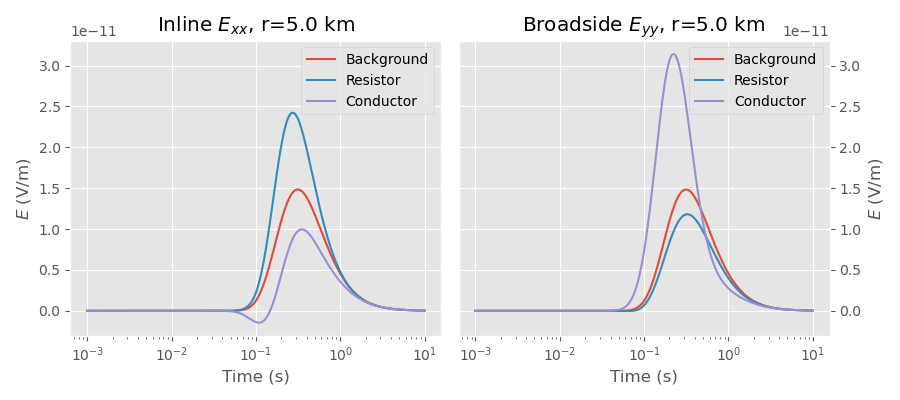

In [6]:
plt.figure(figsize=(9, 4))

ax1 = plt.subplot(121)
plt.title(f"Inline $E_{{xx}}$, r={rec1[0]/1e3} km")

plt.plot(times, resp_bg11, label=f"Background")
plt.plot(times, resp_tg11r, label=f"Resistor")
plt.plot(times, resp_tg11c, label=f"Conductor")

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('$E$ (V/m)')
plt.xscale('log')


ax2 = plt.subplot(122, sharey=ax1)
plt.title(f"Broadside $E_{{yy}}$, r={rec1[0]/1e3} km")

plt.plot(times, resp_bg22, label=f"Background")
plt.plot(times, resp_tg22r, label=f"Resistor")
plt.plot(times, resp_tg22c, label=f"Conductor")

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('$E$ (V/m)')
plt.xscale('log')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.tight_layout()
plt.show()

## Example 2: many offsets, many times

In [7]:
inp_all = {
    'src': src,
    'rec': rec,
    'freqtime': times,
    'signal': signal,
    'verb': 0,
    'epermH': [0, 1, 1, 1],  # To make t-domain early times more stable
    'epermV': [0, 1, 1, 1],
}

# Calculate it
resp_bg11_all = empymod.dipole(depth=depth, res=res_bg, ab=11, **inp_all)
resp_tg11r_all = empymod.dipole(depth=depth, res=res_tgr, ab=11, **inp_all)
val = (resp_tg11r_all-resp_bg11_all)/resp_bg11_all

<IPython.core.display.Javascript object>


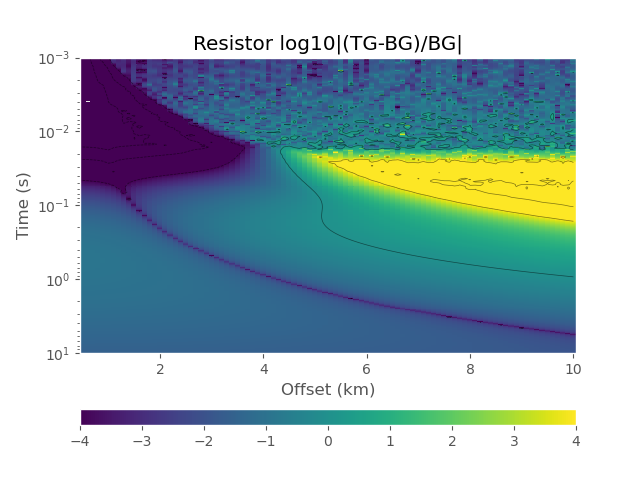

In [8]:
fig, ax = plt.subplots()

ax.set_title('Resistor log10|(TG-BG)/BG|')

# pcolormesh takes x/y as start and end point of pixels,
# not midpoints. So we have to create these.
dx = (off[1]-off[0])/2
ppx = np.r_[off-dx, off[-1]+dx]/1000
lt = np.log10(times)
dt = (lt[1]-lt[0])/2
pt = 10**(np.r_[lt-dt, lt[-1]+dt])

# Plot result
cs = ax.pcolormesh(ppx, pt, np.log10(np.abs(val)), vmin=-4, vmax=4)

## Plot contours at every decade
cs2 = ax.contour(off/1000, times, np.log10(np.abs(val)), linewidths=0.5, colors=[(0, 0, 0, 0.5)])

ax.set_xlabel('Offset (km)')
ax.set_ylabel('Time (s)')
ax.set_yscale('log')
ax.invert_yaxis()

# Plot colorbar
cax, kw = plt.matplotlib.colorbar.make_axes(ax, location='bottom', fraction=.05, aspect=30)
cb = fig.colorbar(cs, cax=cax, **kw)

fig.show()

# Tasks

In the following are two tasks:
1. Influence of (a) reservoir thickness, (b) depth, and (c) contrast
2. Influence of a thin, shallow resistor and conductor

Both tasks can be analyzed for:
- Inline or crossline;
- A resistor or a conductor.

**=> So in total two tasks for four cases.**


## Task 1: Influence of (a) reservoir thickness, (b) depth, and (c) contrast

How does target thickness, target depth, and the contrast between the background and the target affect the detectability?

### Fixed:
- Background fixed at 10 Ohm.m.

### Flexible:
- Vary the target depth from 1 km to 3 km.
- Vary the target thickness from 5 m to 100 m.
- Vary the target resistivity from 10 Ohm.m to 1000 Ohm.m.

### => What are your conclusions?

## Task 2: Influence of a thin, shallow resistor and conductor


### Fixed:
- Target at 2 km below the surface, 300 Ohm.m.
- Background resistivity 10 Ohm.m.

### Flexible:
- Add a thin, shallow layer with the following characteristics:
  - Vary depth between 0 to 500 m.
  - Vary resistivity.
  - Vary thickness up to 20 m.

### => What are your conclusions?

In [9]:
empymod.Report()

--------------------------------------------------------------------------------
  Date: Wed Feb 17 13:06:17 2021 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.8.6 | packaged by conda-forge | (default, Dec 26 2020, 05:05:16)
  [GCC 9.3.0]

             numpy : 1.19.5
             scipy : 1.6.0
             numba : 0.51.2
           empymod : 2.0.3
           IPython : 7.19.0
        matplotlib : 3.3.3

  Intel(R) Math Kernel Library Version 2020.0.1 Product Build 20200208 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------